<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_Lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек

Используйте готовый ноутбук с кластеризацией базы покупок интернет-магазина.

Удалите из выборки все строки про доставку.

Выведите две гистограммы:

Распределения размеров кластеров: сколько корзин

Распределение количества уникальных позиций в кластере

Напишите продвинутую функцию визуализации одного выбранного кластера:

Размер кластера

Количество уникальных позиций

Позиции, которые есть минимум в 20% корзин

Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания монобрендовых и монотоварных закупок

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import utils
from keras.preprocessing.text import Tokenizer, text_to_word_sequence

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

from google.colab import drive

# Загрузка базы

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/БАЗЫ/интернет-кластеризация.csv')

In [ ]:
df[:5]

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
new = df.drop(['Unnamed: 0'], axis=1)
new.insert(0, column='Дата', value= [x for x in range(len(new))])
new = new.fillna('unknow')

In [ ]:
new[:3]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,0,Период: Февраль 2019 г. - Август 2019 г.,unknow,unknow,unknow
1,1,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknow,unknow
2,2,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknow


In [ ]:
new[new['Валовая прибыль'].str.contains('MCOSM')][:5]

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknow
22,22,MCOSM13113,1929,4,unknow
166,166,MCOSM4885,350,2,unknow
168,168,MCOSM4996,9436,4,unknow
172,172,MCOSM5963,8625,6,unknow


In [ ]:
data_list = list(new[new['Валовая прибыль'].str.contains('\d\d.\d\d.2019')].index) # индексы строк, где есть дата
indx = 0
for i in range(len(new)): #бежим по всей новой базе
  if i in data_list: # если есть дата , то присваиваем как индекс формат даты
    indx = i
  new['Дата'][i] = new['Валовая прибыль'][indx]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
new1 = new.copy()

In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index, axis=0) # убираю периоды
new = new.drop(new[new['Валовая прибыль'].str.contains('unknow')].index, axis=0) # убираю в валовой прибыли строки с Unknow
new = new.drop(new[new['Валовая прибыль'].str.contains('Услуга доставки')].index, axis=0) # убираем в валовой прибылт услугу доставки
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index) # убираем в колонке вал. прибыль, стороку где есть дата
new.reset_index(inplace=True)
new = new.drop('index', axis=1)

In [ ]:
new.tail()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
90278,02.09.2019 0:00:00,MCOSM32997,1691,5,unknow
90279,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknow
90280,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknow
90281,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknow
90282,02.09.2019 0:00:00,Шампунь-архитектор волос для восстановления + ...,345,1,unknow


In [ ]:
new.describe()

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,90283,90283,90283,90283,90283
unique,147,20217,5468,148,4
top,25.02.2019 0:00:00,Шампунь для ежедневного применения 1000 мл. Cu...,165,1,unknow
freq,1365,601,2025,59349,90265


In [ ]:
cart_list = list(new[new['Валовая прибыль'].str.contains('MCOSM')].index) # определяем список MCOSM
cafre_list = list(new[new['Валовая прибыль'].str.contains('CAFRE')].index) # определяем список CAFRE

In [ ]:
print(len(cart_list))
print(len(cafre_list))

13567
74


In [ ]:
#  подробно описывал цикл в Ultra Light

carts = [] # пустой лист всех корзин
cart = [] # пустой список текущей корзины
i = 0
val = new['Валовая прибыль'] 
allPositions = [] # пустой список позиций
while i != len(new):
  if i in cart_list:
    if i!=cart_list[-1]: # Если
      ind = cart_list.index(i)
      while i<cart_list[ind+1]:
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1
    else: 
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1
    carts.append(cart)
    cart = []
  else:
    i +=1

## гистограммки

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  


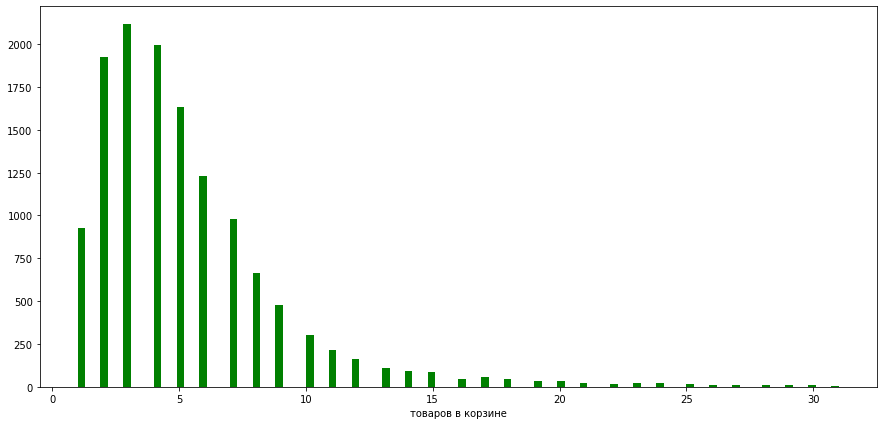

In [ ]:
plt.figure(figsize=(15, 7)) # распределение размеров корзин
plt.hist([len(c) for c in carts], 100, [1, 31], color='G')
plt.xlabel('товаров в корзине')
plt.show()

In [ ]:
n=19
carts[n]

['Карандаш для глаз KOLORIS CLASSIC KL-5 04 Коричневый',
 'Карандаш для глаз KOLORIS CLASSIC KL-5 19 Лазурный',
 'Помада для губ ART SOFFIO L-722 19 Розы Пустыни',
 'Помада для губ ART SOFFIO L-722 35 Классический Шарм',
 'Помада для губ SOFFIO MASTERS S-28 915 Провокация',
 'MCOSM8234']

#  Объект LabelEncoder

In [ ]:
labelEncoder = LabelEncoder() # из библиотеки sklearn
labelEncoder.fit(allPositions) 

LabelEncoder()

In [ ]:
maxPositionsCount = max(labelEncoder.transform(allPositions))+1
print(maxPositionsCount)

20217


In [ ]:
cartsIndexes = [labelEncoder.transform(c) for c in carts]

In [ ]:
n = 234 # корзина
print(carts[n])
print(cartsIndexes[n])

['Гель для душа "Сладкая vanilla" Organic Shop 500 мл', 'Гель-крем для душа "Кокосовый рай" Organic Shop 500 мл', 'Двухфазный лосьон-спрей Интенсивное восстановление 200 мл.', 'Интенсивная маска для восстановления волос OTIUM MIRACLE REVIVE 300 мл.', 'Интенсивная маска для поврежденных волос 500 мл.', 'Комфорт-маска для светлых волос  ESTEL PRIMA BLONDE 300 мл.', 'Насосный дозатор для флаконов 1000 мл.', 'Увлажняющий скраб для тела "100% Богиня" Organic Shop 100 мл', 'Флюид-блеск с термоащитой для всех типов волос 100 мл.', 'Шампунь для ежедневного применения 1000 мл. Curex Classic', 'MCOSM8747']
[16907 16938 16975 17044 17046 17167 18244 19178 19229 19367 14896]


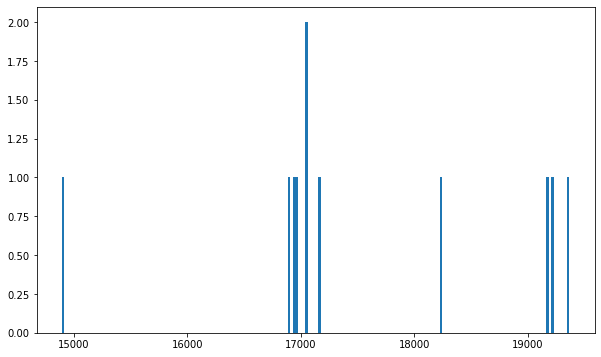

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(cartsIndexes[n], 200)
plt.show()

# Функции

trainVector - исходный вектор индексов слов

wordsCount - установленная длина вектора

trainSet - выборка

In [ ]:
def changeXTo01(trainVector, wordsCount): 
  out = np.zeros(wordsCount)
  for x in trainVector:
    out[x] = 1
  return out

def changeSetTo01(trainSet, wordsCount): # возвращает массив из 0 и 1
  out = []
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount))
  return np.array(out)

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) #  вот это будет длиннющий вектор BOW

In [ ]:
carts01.shape

(13567, 20217)

In [ ]:
n = 185 #  для примера 
print(carts[n])
print(cartsIndexes[n])
print(carts01[n])

['OLLIN PERFECT HAIR OXYMORON Универсальный ухаживающий биокомплекс 2х250мл', 'OLLIN PERFECT HAIR TRES OIL Бальзам для волос 400мл', 'MCOSM8590']
[16060 16061 14801]
[0. 0. 0. ... 0. 0. 0.]


# Кластеризация





In [ ]:
import time

In [ ]:
cur_time = time.time()
clustersCount = 50 # кол-во кластеров
kmean = KMeans(clustersCount) 
kmean.fit(carts01) # кластеризация BOW набора carts01
labels = kmean.labels_

npCarts = np.array(carts)

print(' Время:', round(time.time() - cur_time, 2), 'сек.')

 Время: 310.68 сек.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


In [ ]:
npCarts.shape

(13567,)

In [ ]:
print(labels)
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] #  список каждого кластера
for i, s in enumerate(clusterSize):
  print(i, s)

[25  0 25 ... 20 25 25]
0 5
1 90
2 90
3 67
4 33
5 67
6 47
7 87
8 6
9 1
10 1
11 99
12 1
13 53
14 1
15 1
16 270
17 274
18 258
19 217
20 261
21 1
22 42
23 4
24 207
25 9911
26 50
27 4
28 1
29 1
30 3
31 19
32 456
33 204
34 357
35 1
36 162
37 39
38 1
39 1
40 1
41 26
42 1
43 1
44 1
45 1
46 1
47 7
48 1
49 134


In [ ]:
def getCluster(x):
  clasterSize = x.shape[0] #  размер кластера
  sumX = np.sum(x, axis=0)
  sumX /= clasterSize
  positions = [] # пустой список позиций
  positionValues = [] # пустой список значений

  for i in range(sumX.shape[0]): #  по всем примерам товаров
    if (sumX[i]>0): #  если товар присутствует в кластере
      position = labelEncoder.inverse_transform([i])
      positions.append(position)
      positionValues.append(sumX[i])
  return positions, positionValues

In [ ]:
for clusterNumber in range(len(clusterSize)):
  if (clusterSize[clusterNumber]>5):
    pos, posVal = getCluster(carts01[labels==clusterNumber])# из кластера в BOW получаем позиции и их количество
    print('Покупок', clusterSize[clusterNumber]) # размер текущего кластера
    print('Позиций', len(pos)) # число позиций в кластере
    pos = np.array(pos)
    posVal = np.array(posVal)
    indexes = posVal > 0.2
    indexedPos = pos[indexes]
    indexedPosVal = posVal[indexes]

    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i], 1), '%', indexedPos[i], sep='')
    print()

Покупок 90
Позиций 1146
22.2%['10/0 Стойкая крем-краска яркий блонд']
27.8%['10/16 Стойкая крем-краска яркий блонд пепельно-фиолетовый']
26.7%['10/38 Стойкая крем-краскад/в яркий блонд золотисто']
26.7%['10/8 Стойкая крем-краска яркий блонд жемчужный']
24.4%['10/81 яркий блонд перламутрово-пепельный Интенсивное тонирование НОВЫЙ']
23.3%['10/96 Стойкая крем-краска яркий блонд сандрэ фиолетовый']
22.2%['12/0 Стойкая крем-краска специальный блонд']
42.2%['12/61 Стойкая крем-краска специальный блонд фиолет']
33.3%['12/81 Стойкая крем-краска специальный блонд жемч']
30.0%['12/89 Стойкая крем-краска специальный блонд жемчуж']
36.7%['4/0 Стойкая крем-краска шатен']
27.8%['4/71 Стойкая крем-краска шатен коричнево-пепельный']
36.7%['5/0 Стойкая крем-краска светлый шатен']
26.7%['5/71 Стойкая крем-краска светлый шатен коричнево-п']
36.7%['6/0 Стойкая крем-краска темный блонд']
32.2%['6/7 Стойкая крем-краска темный блонд коричневый']
31.1%['6/71 Стойкая крем-краска темный блонд коричнево-пе']
21.

In [ ]:
#n = 180
#d = indexedPos[::]
#print(d)

## функция отдельного кластера

In [ ]:

def OneCluster(clusterNumber):
  if (clusterSize[clusterNumber]>1):
    pos, posVal = getCluster(carts01[labels==clusterNumber])# из кластера в BOW получаем позиции и их количество
    print('Покупок', clusterSize[clusterNumber]) # размер текущего кластера
    print('Позиций', len(pos)) # число позиций в кластере
    pos = np.array(pos)
    posVal = np.array(posVal)
    indexes = posVal > 0.2
    indexedPos = pos[indexes]
    indexedPosVal = posVal[indexes]
  
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i], 1), '%', indexedPos[i], sep='')
      
    print()

In [ ]:
n = int(input('Введите номер кластера от 1 до 50: ')) 
OneCluster(clusterNumber=n)

Введите номер кластера от 1 до 50: 23
Покупок 4
Позиций 291
25.0%['/116 Крем-краска ESTEL PRINCESS ESSEX перламутровый']
25.0%['1/0 Крем-краска ESTEL PRINCESS ESSEX черный классический']
25.0%['1/0 Черный классический DL']
25.0%['10/0 Светлый блондин DL']
25.0%['10/117 Светлый блондин усиленный пепельно-кор. DL']
25.0%['10/16 светлый блондин пепельно-фиолетовый DLSe']
25.0%['10/6 розовая карамель']
25.0%['10/65 Крем-краска ESTEL PRINCESS ESSEX светлый блондин розовый жемчуг']
25.0%['10/65 светлый блондин фиолетово-красный DLSe']
25.0%['10/76 светлый блондин коричнево-фиолетовый DLSe']
25.0%['10/8 Стойкая крем-краска яркий блонд жемчужный']
25.0%['12/0 Стойкая крем-краска специальный блонд']
25.0%['12/61 Стойкая крем-краска специальный блонд фиолет']
25.0%['12/81 Белое золото Koleston Perfect ME+']
25.0%['12/81 Стойкая крем-краска специальный блонд жемч']
25.0%['12/89 Стойкая крем-краска специальный блонд жемчуж']
25.0%['2 Крем-краска ESTEL PRINCESS ESSEX лиловый']
25.0%['286']
25.0%['2

**Вывод:** есть косяк. доделаю, если что.